In [650]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import pandas as pd

Relevant functions found in: **Add to another file**

In [651]:
def annotate_scatter_points(points,fig,ax):
    """
    Annotate scatter plot points with point numbers.

    Parameters:
    - points: List of (x, y) coordinates for scatter plot.

    Example:
    annotate_scatter_points([[0, 0], [1, 1], [2, 3], [2, 5]])
    """

    for i, (x, y) in enumerate(points, 1):
        ax.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Example usage 'annotate_scatter_points([[0, 0], [1, 1], [2, 3], [2, 5]],fig,axeee)''

In [652]:
def extract_substances(dataframe):
    # Get the column names from the DataFrame
    columns = dataframe.columns

    # Create a dictionary to store the count of each unique substance
    substance_counts = {}

    # Extract unique substances from the column names and count occurrences
    for column in columns:
        # Split the column name based on the numeric part
        substance = ''.join([i for i in column if not i.isdigit()])
        
        # Update the count in the dictionary
        substance_counts[substance] = substance_counts.get(substance, 0) + 1

    # Convert the dictionary to two lists (substances and counts) and sort them
    unique_substances_list = sorted(list(substance_counts.keys()))
    counts_list = [substance_counts[substance] for substance in unique_substances_list]

    return unique_substances_list,counts_list

In [653]:
def get_fp_data(fpc_object,pcs = 2,gridpoints = np.arange(360)):
    """
    'Inputs'
    fpc_obj - functional data object already in pca form (1-D)
    pcs - number of functional principal components to take into account (int)
    
    'Outputs'
    np.arr - X array (gridpoints)
    np.arr 2D - Y arrays (data points - no. fpcs - 2 by default)
    """
    fpc_grid_points = fpc_object.components_.to_grid(gridpoints).grid_points[0]
    fpc_data_points = [np.zeros_like(fpc_grid_points) for i in range(pcs)]
    fpc_variance_exp = np.array([fpc_object.explained_variance_ratio_[i] for i in range(pcs)])
    for i in range(pcs):
        fpc_data_points[i] = fpc_object.components_.to_grid(gridpoints)[i].data_matrix[0].flatten()
        
    return fpc_grid_points,fpc_data_points,fpc_variance_exp

In [654]:
#define parameters
specie = {'E':'Erpobdella','G':'Gammarus','R':'Radix'}
specie_dim = {'E':'X','G':'Y','R':'Z'}

In [655]:
#locate files and load data for each species
directory = r'D:\VP\ARTICLE2\ArticleData'
data = {}
for s in specie:
    file = r'{}\{}_{}_i_data.csv'.format(directory,s,specie_dim[s])
    print(file)
    data.update({s:pd.read_csv(file)})

if 'm_data' in file:
    mean = True #if IGT should be false
else:
    mean = False

D:\VP\ARTICLE2\ArticleData\E_X_i_data.csv
D:\VP\ARTICLE2\ArticleData\G_Y_i_data.csv
D:\VP\ARTICLE2\ArticleData\R_Z_i_data.csv


In [660]:
#Data Transformations for data with camera calibration error
calibration_mean,calibration_IGT = {'E':{},'G':{4:1.5,16:1.5},'R':{21:0.6,0:1.2}},{s:{} for s in specie}

if mean: 
    rules = calibration_mean
else:
    rules = calibration_IGT

In [657]:
data['E'].head()

,Copper0,Copper1,Copper2,Copper3,Copper4,Copper5,Copper6,Copper7,Methomyl0,Methomyl1,...,Methomyl4,Methomyl5,Methomyl6,Verapamil0,Verapamil1,Verapamil2,Zinc0,Zinc1,Zinc2,Zinc3
0,0.000000,0.013496,0.010313,0.006673,0.004786,0.185005,0.0,0.045759,0.0,0.0,...,0.0,0.027120,0.0,0.005985,0.0,0.017634,0.0,0.024239,0.027087,0.000000
1,0.004483,0.016588,0.010062,0.005755,0.004799,0.181456,0.0,0.038471,0.0,0.0,...,0.0,0.025385,0.0,0.005561,0.0,0.017054,0.0,0.028436,0.035160,0.000000
2,0.000000,0.014006,0.009641,0.005196,0.004684,0.180394,0.0,0.031634,0.0,0.0,...,0.0,0.024105,0.0,0.005051,0.0,0.015857,0.0,0.034271,0.039412,0.004712
3,0.000000,0.011910,0.009293,0.005245,0.004482,0.178462,0.0,0.027380,0.0,0.0,...,0.0,0.022787,0.0,0.004525,0.0,0.013629,0.0,0.039724,0.038390,0.005609
4,0.000000,0.010553,0.009516,0.005864,0.007022,0.178143,0.0,0.024033,0.0,0.0,...,0.0,0.021368,0.0,0.005905,0.0,0.013543,0.0,0.032204,0.038384,0.005814


In [661]:
rules

{'E': {}, 'G': {}, 'R': {}}

In [662]:
for s in specie:
    df = data[s].copy()
    for key in rules[s]:
        df[df.columns[key]] = df[df.columns[key]] * rules[s][key]
    data[s] = df

In [663]:
#identify all used substances
substances,counts = extract_substances(data[[*data][0]])
for i in range(4): print('{}: {} repetitions'.format(substances[i],counts[i]))
subcounts = dict(zip(substances,counts))

Copper: 8 repetitions
Methomyl: 7 repetitions
Verapamil: 3 repetitions
Zinc: 4 repetitions


In [664]:
#colours inspired from plotly
plot_colors = {'Copper':'#8c564b','Methomyl':'#9467bd','Verapamil':'#d62728','Zinc':'#e377c2'}
fpc_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
custom_palette = [plot_colors[s] for s in plot_colors]
sns.set_palette(custom_palette)
custom_palette

['#8c564b', '#9467bd', '#d62728', '#e377c2']

In [665]:
#Define columns and y values for functional data analysis
cols = data[[*data][0]].columns
y = ['{}'.format(s) for i,s in enumerate(substances) for x in range(counts[i])]
y

['Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Copper',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Methomyl',
 'Verapamil',
 'Verapamil',
 'Verapamil',
 'Zinc',
 'Zinc',
 'Zinc',
 'Zinc']

In [666]:
#custom legend handles
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=plot_colors[sub], label=sub) for sub in substances]

Text(0, 0.5, 'Normalised mean amplitude')

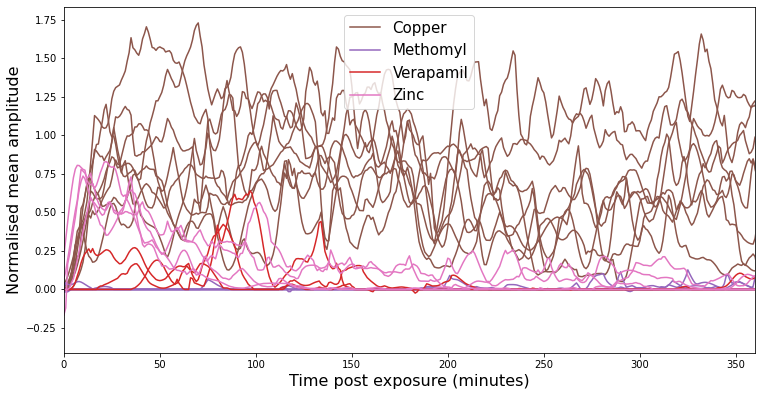

In [667]:
#plot for individual species
fig = plt.figure(figsize = (12,6))
axe = fig.add_axes([0.1,0.1,0.8,0.8])
sp = 'G'
for x,col in enumerate(data[sp].columns):
    axe.plot(data[sp].index,data[sp][col].values,color = plot_colors[y[x]])
    
axe.legend(handles = legend_handles,fontsize = 15)
axe.set_xlim([0,360])

axe.set_xlabel('Time post exposure (minutes)',fontsize = 16)
axe.set_ylabel('Normalised mean amplitude',fontsize = 16)

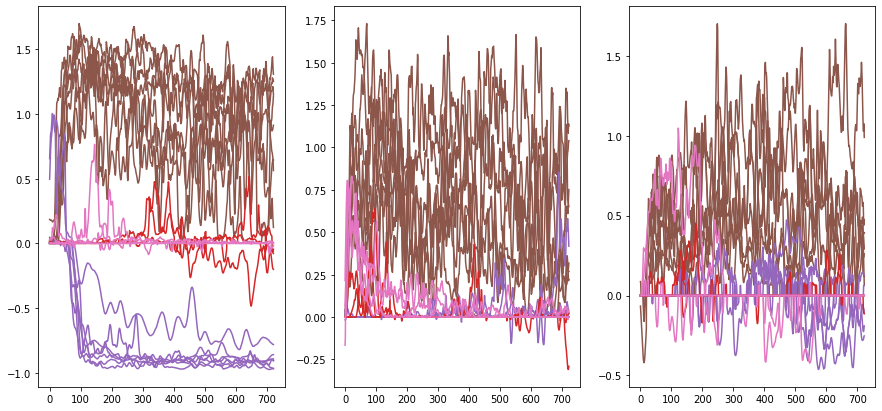

In [668]:
fig,axes = plt.subplots(1,3,figsize=(15,7))
for i,s in enumerate(specie):
    for x,col in enumerate(data[s].columns):
        axes[i].plot(data[s].index,data[s][col].values,color = plot_colors[y[x]])

Functional BSpline approx

In [669]:
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis

In [670]:
#Define timestep for data and extract first 2 hours (60 * 2 * 3) - timesteps 20s
timestep = 30
full_length = data[[*data][0]].shape[0]
#n_rows = (full_length//timestep)*timestep
n_rows = 360
#Cut dataframe at n_rows
for s in specie:
    data[s] = data[s].iloc[:n_rows]
    
data[s].shape

(360, 22)

Explain

In [671]:
#define FDA parameters with uneven knots
domain_range = (0,n_rows)
order = 4

#define knots with uneven spacing
knots = np.hstack((np.array([0,30,60,90]),np.arange(180,n_rows+90,90)))
#knots = np.hstack((np.array([0,30,60,90,120,150]),np.arange(180,181)))

n_basis = len(knots) + order - 2

bbs = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)
print('FDA knots')
knots

FDA knots


array([  0,  30,  60,  90, 180, 270, 360])

In [672]:
#define grid points and data matrices
grid_points = np.arange(n_rows)
data_matrices = {s:np.transpose(np.array(data[s].iloc[:n_rows])) for s in specie}

#define functional data grids
fds = {s:FDataGrid(data_matrix=data_matrices[s],grid_points=grid_points,) for s in specie}

Create basis functions

In [673]:
#create basis functions
bss = BSplineBasis(domain_range = domain_range,n_basis = n_basis,order = order,knots = knots)

In [674]:
#basis dictionary per species
X_bss = {s:fds[s].to_basis(bss) for s in specie}

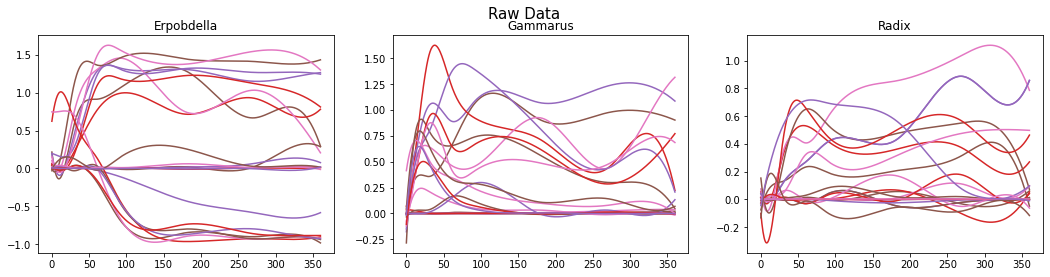

In [675]:
#plot b spline functinos
#sort colors error
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('Raw Data',fontsize = 15)
for i,s in enumerate(specie): 
    X_bss[s].plot(axes = axe[i])
    axe[i].set_title(specie[s])

Convert BSpline functional data back to array of smoothed points

In [676]:
#bspline approximations as array
X_grid = {s:X_bss[s].to_grid(grid_points = np.arange(n_rows)) for s in specie}

(0.0, 360.0)

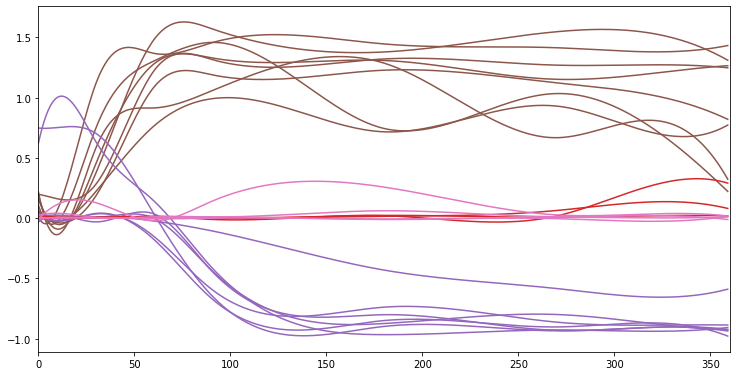

In [677]:
#plot for individual species
fig = plt.figure(figsize = (12,6))
axe = fig.add_axes([0.1,0.1,0.8,0.8])
sp = 'E'
for x,col in enumerate(data[sp].columns):
    axe.plot(X_grid[sp].grid_points[0],X_grid[sp].data_matrix[x].flatten(),color = plot_colors[y[x]])
axe.set_xlim([0,360])

In [678]:
X_grid[sp].data_matrix[:,0].min()

-0.03179857928276743

Text(0, 0.5, 'Normalised mean amplitude')

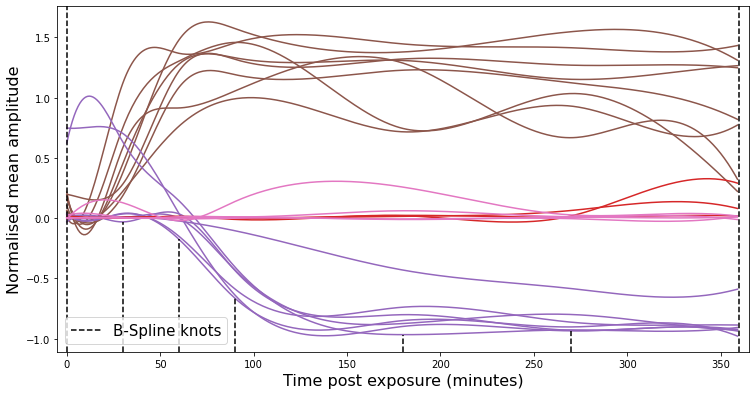

In [679]:
#Same plot but with knots visible
#plot for individual species
fig = plt.figure(figsize = (12,6))
axe = fig.add_axes([0.1,0.1,0.8,0.8])
for x,col in enumerate(data[sp].columns):
    axe.plot(X_grid[sp].grid_points[0],X_grid[sp].data_matrix[x].flatten(),color = plot_colors[y[x]])
    
y_min, y_max = axe.get_ylim()
for knot in knots[1:-1]: 
    knot_min = X_grid[sp].data_matrix[:,knot].min()
    ymax = (knot_min - y_min) / (y_max - y_min)
    axe.axvline(knot,ymax = ymax,color = 'black',linestyle = '--')
axe.axvline(0,color = 'black',linestyle = '--')
axe.axvline(360,color = 'black',linestyle = '--')
axe.set_xlim([-5,365])

legend_handles = [
    Line2D([0], [0], color='#000000', label='B-Spline knots',linestyle = '--')
]
plt.legend(handles=legend_handles,fontsize = 15)

axe.set_xlabel('Time post exposure (minutes)',fontsize = 16)
axe.set_ylabel('Normalised mean amplitude',fontsize = 16)

# FPCA

In [680]:
from skfda.exploratory.visualization import FPCAPlot
from skfda.preprocessing.dim_reduction import FPCA

In [681]:
fpcas = {s: FPCA(n_components=2).fit(X_bss[s]) for s in specie}

In [682]:
#FDA components
fpcas['E'].components_

FDataBasis(
    basis=BSplineBasis(domain_range=((0.0, 360.0),), n_basis=9, order=4, knots=(0, 30, 60, 90, 180, 270, 360)),
    coefficients=[[-0.00202456 -0.01547243  0.01271549  0.03961894  0.06493992  0.05588848
       0.06015942  0.05773383  0.05358119]
     [ 0.06327307  0.0569956   0.14883557  0.10551357  0.01446498 -0.03989159
       0.00946463 -0.03560315 -0.05263075]],
    dataset_name=None,
    argument_names=(None,),
    coordinate_names=(None,),
    extrapolation=None)

### Plot for FPCA components

*Easily adapted for any species*

Text(0.5, 1.0, 'Functional Principal Component plot')

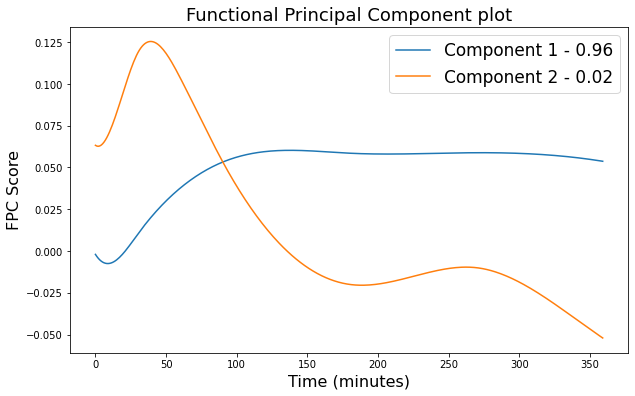

In [683]:
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(fpcas['E'],gridpoints = np.arange(n_rows))

#plot each component
fig,ax = plt.subplots(figsize = (10,6))
ax.plot(grid_points,data_points[0],color = fpc_colors[0])
ax.plot(grid_points,data_points[1],color = fpc_colors[1])
ax.legend(labels=['Component 1 - {:.2f}'.format(variances[0]),
                  'Component 2 - {:.2f}'.format(variances[1])],
         fontsize = 17)
ax.set_xlabel('Time (minutes)',fontsize = 16)
ax.set_ylabel('FPC Score',fontsize = 16)
ax.set_title('Functional Principal Component plot',fontsize = 18)

Text(0.5, 1.0, 'Functional Principal Component plot')

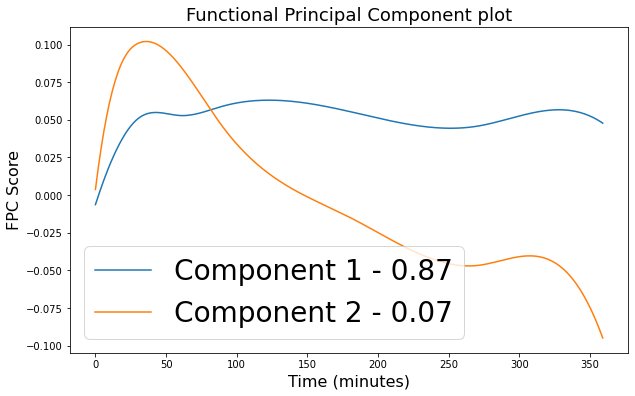

In [684]:
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(fpcas['G'],gridpoints = np.arange(n_rows))

#plot each component
fig,ax = plt.subplots(figsize = (10,6))
ax.plot(grid_points,data_points[0],color = fpc_colors[0])
ax.plot(grid_points,data_points[1],color = fpc_colors[1])
ax.legend(labels=['Component 1 - {:.2f}'.format(variances[0]),
                  'Component 2 - {:.2f}'.format(variances[1])],
         fontsize = 28)
ax.set_xlabel('Time (minutes)',fontsize = 16)
ax.set_ylabel('FPC Score',fontsize = 16)
ax.set_title('Functional Principal Component plot',fontsize = 18)

Text(0.5, 1.0, 'Functional Principal Component plot')

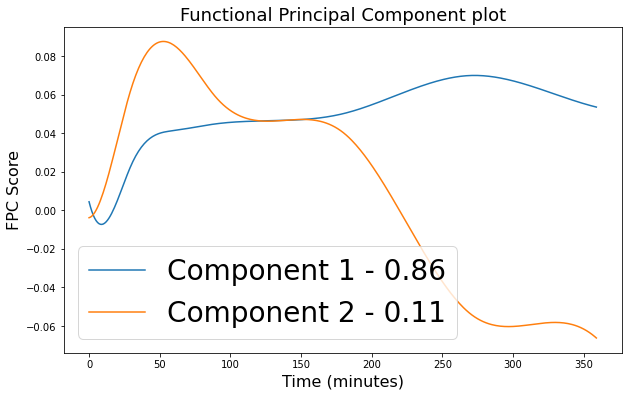

In [685]:
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(fpcas['R'],gridpoints = np.arange(n_rows))

#plot each component
fig,ax = plt.subplots(figsize = (10,6))
ax.plot(grid_points,data_points[0],color = fpc_colors[0])
ax.plot(grid_points,data_points[1],color = fpc_colors[1])
ax.legend(labels=['Component 1 - {:.2f}'.format(variances[0]),
                  'Component 2 - {:.2f}'.format(variances[1])],
         fontsize = 28)
ax.set_xlabel('Time (minutes)',fontsize = 16)
ax.set_ylabel('FPC Score',fontsize = 16)
ax.set_title('Functional Principal Component plot',fontsize = 18)

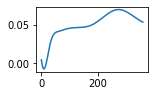

In [686]:
#plot each seperately with no legend
fig,ax = plt.subplots(figsize = (2,1.2))
ax.plot(grid_points,data_points[0],color = fpc_colors[0])

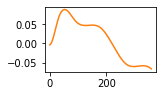

In [687]:
#plot each seperately with no legend
fig,ax = plt.subplots(figsize = (2,1.2))
ax.plot(grid_points,data_points[1],color = fpc_colors[1])

**Grouped fPCA scoreplot without annotation**

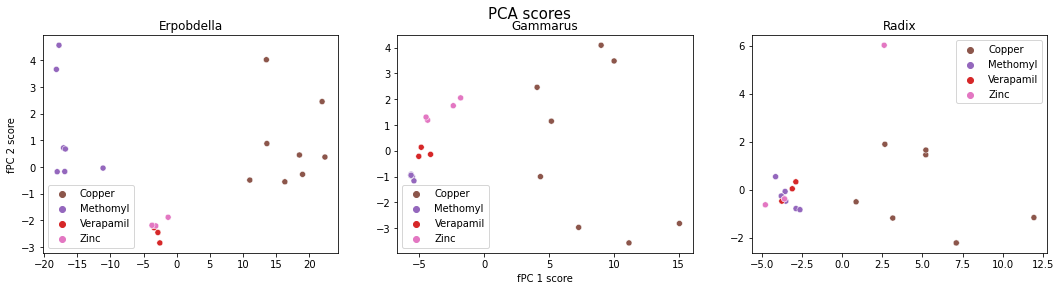

In [688]:
#Show all PCAs as FPCA scores plot
scores = {s:fpcas[s].fit_transform(X_bss[s]) for s in specie}

fig_FPCA,ax_FPCA = plt.subplots(1,3,figsize=(18,4))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA[1].set_xlabel("fPC 1 score")
ax_FPCA[0].set_ylabel("fPC 2 score")

for i,s in enumerate(specie):
    sns.scatterplot(x=scores[s][:, 0], y=scores[s][:, 1],hue = y,ax = ax_FPCA[i])
    ax_FPCA[i].set_title(specie[s])  

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

*Single fPCA plot*

In [689]:
temp = scores['E']
vals = [i for i in range(len(y)) if y[i] == 'Copper']
np.mean(temp[vals],axis = 0)

array([17.04210724,  0.85591562])

In [690]:
cluster_centres_dict = {}

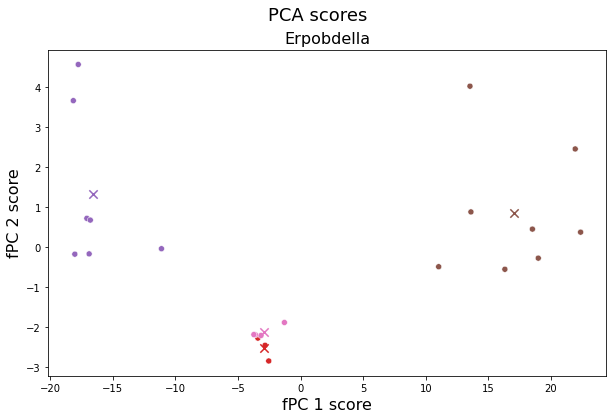

In [691]:
fig_FPCA,ax_FPCA = plt.subplots(figsize = (10,6))
fig_FPCA.suptitle('PCA scores',fontsize = 18)

ax_FPCA.set_xlabel("fPC 1 score",fontsize = 16)
ax_FPCA.set_ylabel("fPC 2 score",fontsize = 16)

sp = 'E'
sns.scatterplot(x=scores[sp][:, 0], y=scores[sp][:, 1],hue = y,ax = ax_FPCA,legend = False)
ax_FPCA.set_title(specie[sp],fontsize = 16)
#ax_FPCA.legend(fontsize=16)

#calculate cluster centre means
cluster_centres = np.zeros((len(substances),2))
for i,substance in enumerate(substances):
    vals = [i for i in range(len(y)) if y[i] == substance]
    cluster_centre = np.mean(scores[sp][vals],axis = 0)
    cluster_centres[i] = cluster_centre
    plt.scatter(cluster_centre[0], cluster_centre[1], marker='x', color=plot_colors[substance], s=70)

cluster_centres_dict.update({sp:cluster_centres})
    
#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

Gammarus fPCA

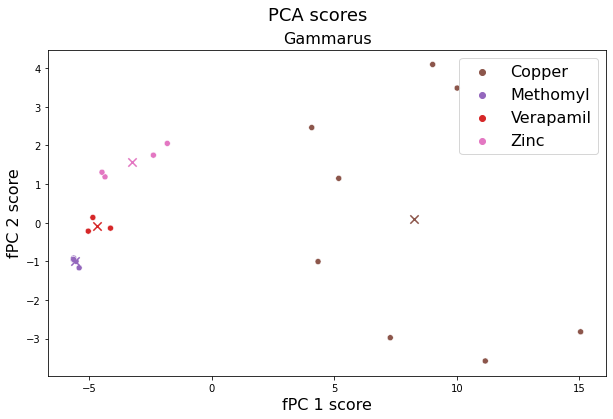

In [692]:
fig_FPCA,ax_FPCA = plt.subplots(figsize = (10,6))
fig_FPCA.suptitle('PCA scores',fontsize = 18)

ax_FPCA.set_xlabel("fPC 1 score",fontsize = 16)
ax_FPCA.set_ylabel("fPC 2 score",fontsize = 16)

sp = 'G'
sns.scatterplot(x=scores[sp][:, 0], y=scores[sp][:, 1],hue = y,ax = ax_FPCA,legend = True)
ax_FPCA.set_title(specie[sp],fontsize = 16)
ax_FPCA.legend(fontsize=16)

#calculate cluster centre means
cluster_centres = np.zeros((len(substances),2))
for i,substance in enumerate(substances):
    vals = [i for i in range(len(y)) if y[i] == substance]
    cluster_centre = np.mean(scores[sp][vals],axis = 0)
    cluster_centres[i] = cluster_centre
    plt.scatter(cluster_centre[0], cluster_centre[1], marker='x', color=plot_colors[substance], s=70)
    
cluster_centres_dict.update({sp:cluster_centres})

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

Radix fPCA

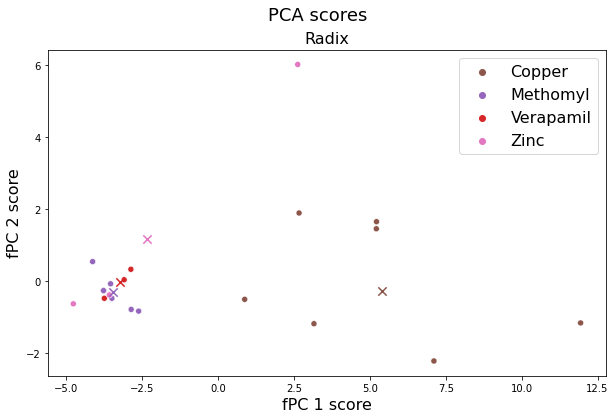

In [693]:
fig_FPCA,ax_FPCA = plt.subplots(figsize = (10,6))
fig_FPCA.suptitle('PCA scores',fontsize = 18)

ax_FPCA.set_xlabel("fPC 1 score",fontsize = 16)
ax_FPCA.set_ylabel("fPC 2 score",fontsize = 16)

sp = 'R'
sns.scatterplot(x=scores[sp][:, 0], y=scores[sp][:, 1],hue = y,ax = ax_FPCA,legend = True)
ax_FPCA.set_title(specie[sp],fontsize = 16)
ax_FPCA.legend(fontsize=16)

#calculate cluster centre means
cluster_centres = np.zeros((len(substances),2))
for i,substance in enumerate(substances):
    vals = [i for i in range(len(y)) if y[i] == substance]
    cluster_centre = np.mean(scores[sp][vals],axis = 0)
    cluster_centres[i] = cluster_centre
    plt.scatter(cluster_centre[0], cluster_centre[1], marker='x', color=plot_colors[substance], s=70)
    
cluster_centres_dict.update({sp:cluster_centres})

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

### Projections

In [694]:
def get_fingerprint(x,cluster_centres,X_mean,data_points):
    """ 
    Get the xth fingerprint 
    Cluster fPCA centre xth entry in cluster_centres
    X_mean offsets points
    datapoints[0] is fPC1
    datapoints[1] is fPC2
    """
    centre = cluster_centres[x]
    cluster_centre = data_points[0]*centre[0] + data_points[1]*centre[1]
    return cluster_centre + X_mean

Text(0, 0.5, 'Normalised mean response')

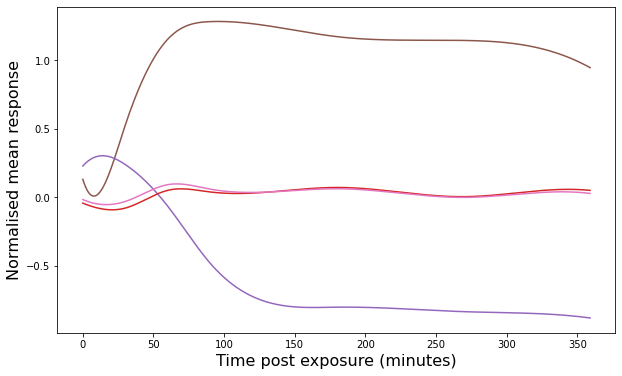

In [695]:
sp = 'E'
fingerprints = {sub:np.zeros((n_rows,)) for sub in substances}
X_mean = np.mean(X_grid[sp].data_matrix,axis = 0).flatten()
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(fpcas['E'],gridpoints = np.arange(n_rows))
#fPC_cluster_centre = data_points[0]*cluster_centres[0,0] + data_points[1]*cluster_centres[0,1]
#fPC_cluster_centre = fPC_cluster_centre + np.mean(X_grid[sp].data_matrix,axis = 0).flatten()

#plot each component
fig,ax = plt.subplots(figsize = (10,6))
for i,substance in enumerate(substances):
    fPC_cluster_centre = get_fingerprint(i,cluster_centres_dict[sp],X_mean,data_points)
    fingerprints[substance] = fPC_cluster_centre
    ax.plot(grid_points,fPC_cluster_centre,color = plot_colors[substance])
#ax.plot(grid_points,X_mean,color = 'black', linestyle = '--')
    
ax.set_xlabel('Time post exposure (minutes)',fontsize = 16)
ax.set_ylabel('Normalised mean response',fontsize = 16)

### Fingerprints Bold

In [696]:
y_min, y_max = axe.get_ylim()

Text(0, 0.5, 'Normalised mean response')

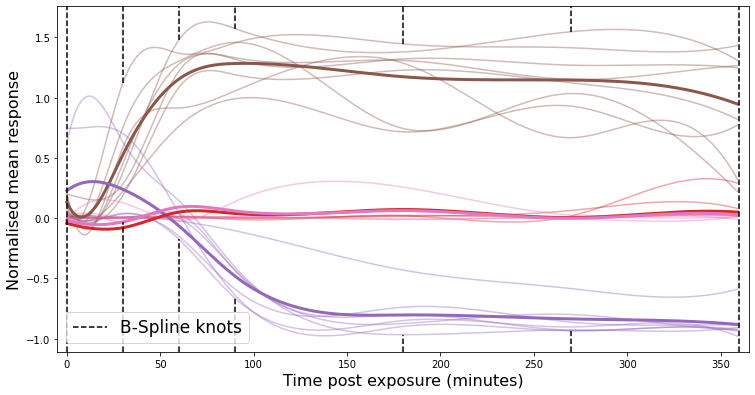

In [697]:
#plot for individual species
fig = plt.figure(figsize = (12,6))
axe = fig.add_axes([0.1,0.1,0.8,0.8])
sp = 'E'
for x,col in enumerate(data[sp].columns):
    axe.plot(X_grid[sp].grid_points[0],X_grid[sp].data_matrix[x].flatten(),color = plot_colors[y[x]],alpha = 0.4)
for sub in substances:
    axe.plot(X_grid[sp].grid_points[0],fingerprints[sub],color = plot_colors[sub],linewidth=3)
    
y_min, y_max = axe.get_ylim()
for knot in knots[1:-1]: 
    knot_min = X_grid[sp].data_matrix[:,knot].min()
    knot_max = X_grid[sp].data_matrix[:,knot].max()
    ymin = (knot_min - y_min) / (y_max - y_min)
    ymax = (knot_max - y_min) / (y_max - y_min)
    axe.axvline(knot,ymax = ymin,color = 'black',linestyle = '--')
    axe.axvline(knot,ymin = ymax,color = 'black',linestyle = '--')
axe.axvline(0,color = 'black',linestyle = '--')
axe.axvline(360,color = 'black',linestyle = '--')
axe.set_xlim([-5,365])

legend_handles = [
    Line2D([0], [0], color='#000000', label='B-Spline knots',linestyle = '--')
]
plt.legend(handles=legend_handles,fontsize = 17)

axe.set_xlabel('Time post exposure (minutes)',fontsize = 16)
axe.set_ylabel('Normalised mean response',fontsize = 16)

*Single fPCA plot with annotations*

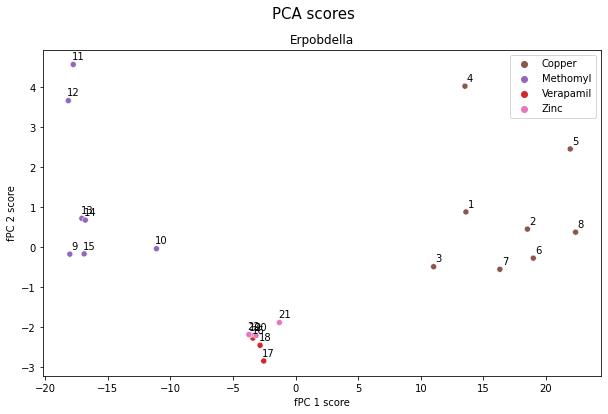

In [698]:
fig_FPCA,ax_FPCA = plt.subplots(figsize = (10,6))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA.set_xlabel("fPC 1 score")
ax_FPCA.set_ylabel("fPC 2 score")

sp = 'E'
sns.scatterplot(x=scores[sp][:, 0], y=scores[sp][:, 1],hue = y,ax = ax_FPCA)
annotate_scatter_points(scores[sp],fig_FPCA,ax_FPCA)
ax_FPCA.set_title(specie[sp])

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

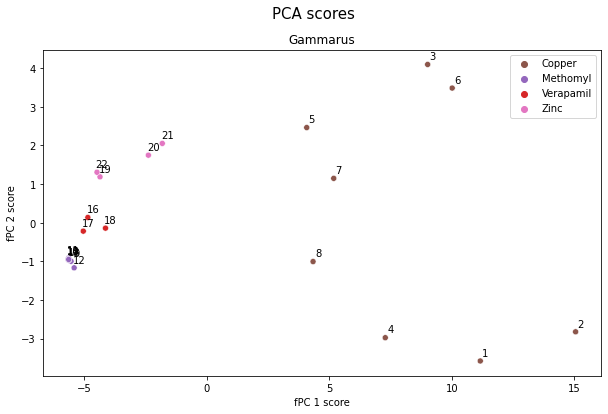

In [699]:
fig_FPCA,ax_FPCA = plt.subplots(figsize = (10,6))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA.set_xlabel("fPC 1 score")
ax_FPCA.set_ylabel("fPC 2 score")

sp = 'G'
sns.scatterplot(x=scores[sp][:, 0], y=scores[sp][:, 1],hue = y,ax = ax_FPCA)
annotate_scatter_points(scores[sp],fig_FPCA,ax_FPCA)
ax_FPCA.set_title(specie[sp])

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

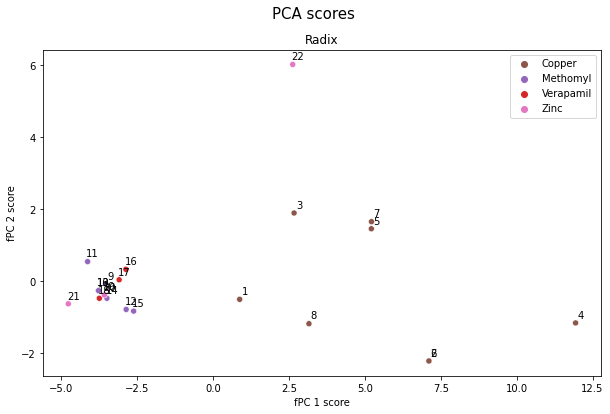

In [700]:
fig_FPCA,ax_FPCA = plt.subplots(figsize = (10,6))
fig_FPCA.suptitle('PCA scores',fontsize = 15)

ax_FPCA.set_xlabel("fPC 1 score")
ax_FPCA.set_ylabel("fPC 2 score")

sp = 'R'
sns.scatterplot(x=scores[sp][:, 0], y=scores[sp][:, 1],hue = y,ax = ax_FPCA)
annotate_scatter_points(scores[sp],fig_FPCA,ax_FPCA)
ax_FPCA.set_title(specie[sp])

#ax_meanFPCA.tick_params(labelsize = 13)
plt.show()

Substance plot for individual repetitions

In [701]:
subcounts

{'Copper': 8, 'Methomyl': 7, 'Verapamil': 3, 'Zinc': 4}

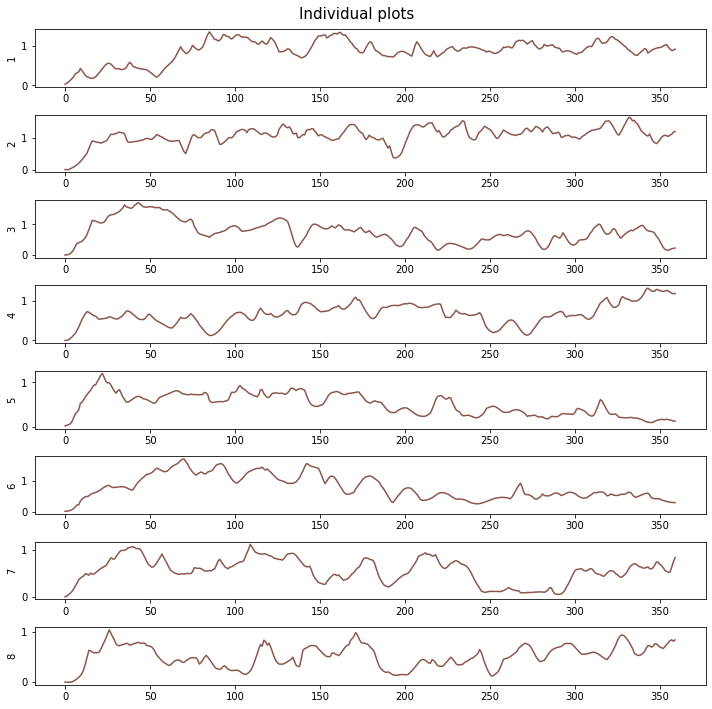

In [702]:
sub = 'Copper'
sp = 'G'
n = subcounts[sub]
fig_FPCA,ax_FPCA = plt.subplots(n,1,figsize=(10,10))
fig_FPCA.suptitle('Individual plots',fontsize = 15)
for i,ax in enumerate(ax_FPCA):
    ax.plot(data[sp].index,data[sp]['{}{}'.format(sub,i)].values)
    ax.set_ylabel(i+1)
plt.tight_layout()

# Multidimensional Clustering

In [703]:
from skfda.representation.basis import VectorValuedBasis

In [704]:
data_vector_matrix = np.transpose(np.array([np.array(data[s].iloc[:n_rows]) for s in specie]))
vector_fd = FDataGrid(data_matrix=data_vector_matrix,grid_points=grid_points,)
vector_bss = VectorValuedBasis([bss for i in range(3)])
vector_bss = vector_fd.to_basis(vector_bss)

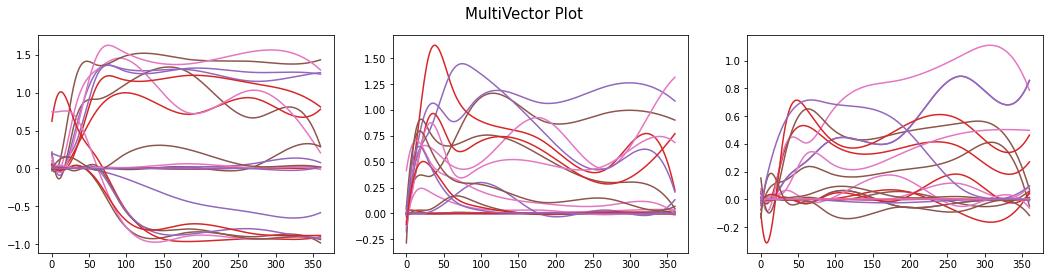

In [705]:
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector Plot',fontsize = 15)
vector_bss.plot(axes = axe)
plt.show()

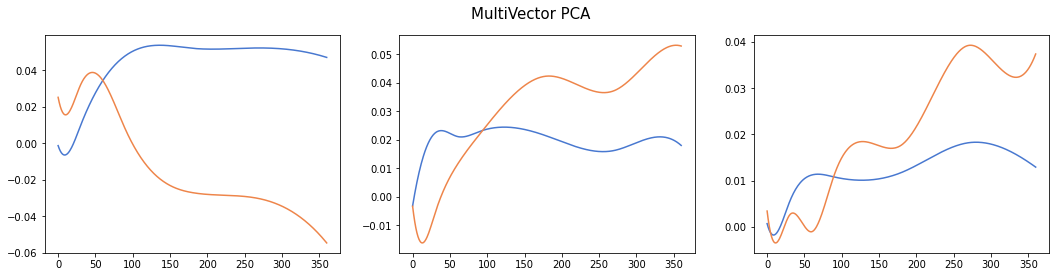

In [706]:
sns.set_palette('muted')
fig,axe = plt.subplots(1,3,figsize = (18,4))
fig.suptitle('MultiVector PCA',fontsize = 15)
vector_fpca = FPCA(n_components=2).fit(vector_bss)
vector_fpca.components_.plot(axes = axe)
plt.show()

In [707]:
#get explained variance?
#Convert fpc1 and fpc2 to np.arrays
grid_points,data_points,variances = get_fp_data(vector_fpca,gridpoints = np.arange(n_rows))

In [708]:
variances

array([0.88125454, 0.04736516])

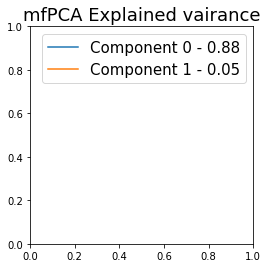

In [710]:
fig,axe = plt.subplots(1,1,figsize = (4,4))
variance_handles = [Line2D([0], [0], color = fpc_colors[i], label='Component {} - {:.2f}'.format(i,variances[i])) for i in range(2)]
axe.legend(handles = variance_handles,fontsize = 15)
axe.set_title('mfPCA Explained vairance',fontsize = 18)
plt.show()

In [711]:
sns.set_palette(custom_palette)

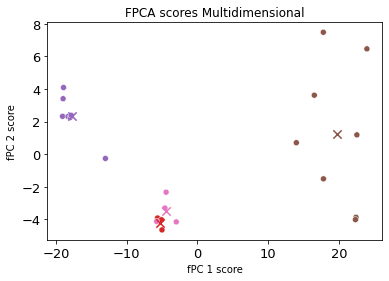

In [712]:
scores = vector_fpca.fit_transform(vector_bss)
fig_vector_FPCA,ax_vector_FPCA = plt.subplots(figsize=(6, 4))
sns.scatterplot(x=scores[:, 0], y=scores[:, 1],hue = y,ax = ax_vector_FPCA,legend = False)
ax_vector_FPCA.set_xlabel("fPC 1 score")
ax_vector_FPCA.set_ylabel("fPC 2 score")
ax_vector_FPCA.set_title("FPCA scores Multidimensional")

#calculate cluster centre means
cluster_centres_md = np.zeros((len(substances),2))
for i,substance in enumerate(substances):
    vals = [i for i in range(len(y)) if y[i] == substance]
    cluster_centre_md = np.mean(scores[vals],axis = 0)
    cluster_centres_md[i] = cluster_centre_md
    plt.scatter(cluster_centre_md[0], cluster_centre_md[1], marker='x', color=plot_colors[substance], s=70)

ax_vector_FPCA.tick_params(labelsize = 13)
plt.show()